# Tutorial 04, Intro to machine learning/pattern recognition, Part I

## Machine learning, or pattern recognition, refers to a large set of tools that are used in many areas of science in any case where you are trying to use multiple measured variables to determine if information is encoded about different levels of an experimental manipulation. 
* To the extent that there is information in a pattern of measured responses, then the pattern recognition algorithm will be able to successfully assign different examplars into their correct classes.
* If there is no information, then it the pattern recognition algorithm will randomly guess and classifation accuracy will be at chance. 
* Note that the 'pattern' part of 'pattern recognition' refers to the fact that we're not just going to use a single variable to predict our outcome measure - we're going  to use the information encoded by a series of variables to make predictions (i.e. a 'multivariate' analysis).
* The multivariate nature of the method is a major advantage as you might infer a null relationship based on univariate methods when in fact there is a very robust relationship that can be revealed by exploiting information encoded in a pattern of measurements. 

<div class="alert alert-info">

**Cross-validation** : To assess the generalizability of a pattern classification algorithm. Cross-validation simply refers to the notion that you train your pattern recognition algorithm (henceforth I'll call this a 'classifer') using one set of data, and then you validate, or 'test', the performance of the classifier using a novel set of data that was not part of the training set. The main purpose of cross-validation is to assess the generalizability of your classifier and its ability to correctly categorize novel inputs.

This sounds simple but can be tricky...suppose you did an experiment that had 500 trials of stimulus type A and 500 trials of stimulus type B and you measured the response on each trial in 100 neurons. 

Then, to figure out how well the neural data respond systematically to changes in stimulus parameters, you  fit a multivariate regression analysis to see how much variability in the stimulus is accounted for by changes in neural activity (i.e. you compute something akin to a R^2 value to asses goodness of fit). Suppose you run this analysis on all 1,000 trials and you get your R^2 value and its nice and high - like .75 or so. You might be really happy with this, however, since you fit all of the data in your model, your estimate of how good the model fits the data is almost certainly overestimating how good the model is at accounting for the relationship between the two factors because your dependent variables  (your measured neural responses) are corrupted by noise, and this noise is idiosyncratic in the sense that if you were to perform the experiment again, you'd get 1000 different measurements that were similar to the first 1000, but corrupted by different noise. 

As a result, when you fit your model to the data, the resulting coeffecients will reflect the true 'signal' in the data AND the idiosyncratic noise that was measured along with the signal. In effect, your model learns the relationship between the independent variable and the (signal + noise). This occurs because your model has no a priori means of separating out signal and noise - it just gets a measure of neural responses that were evoked by each stimulus, and the model is just relating those measurements to the independent variables. This is referred to as 'overfitting', and is a exacerbated by small data sets (where the signal is not likely to emerge from the noise due to the small sample size) and when you have a model that has lots of free parameters (more free parameters means that the model can more flexibly account for random variations in the data...i.e. noise).  
So - what to do? Instead of fitting the model to all the data and assessing the goodness of fit, you could use cross-validation to estimate **prediction accuracy**. In our example above, you could train your classifer using 400/500 of the trials associated with each stimulus set (so 800 trials total), and then 'test' the classifer's performance at guessing the correct stimulus class using the remaining 200 trials (100 associated with each stimulus). 

Then you could permute this train/test procedure several times, each time holding-out a different set of 800 trials to train the classifer and 200 trials to test the performance of the classifier. Here is the cool part: if your model is just learning the idiosyncratic noise in the data, then you might have a reasonable looking R^2 value based on your training data (i.e. the model fits the training data ok), but your ability to classify novel examplars from the test set will be at chance becuase your model just learned the random noise in the training set and there was no consistent 'signal' that could actually discriminate between conditions. 

So, the use of cross-validation can protect against overly optimistic assessments of model fit due to 'overfitting', and also enables you to assess the generalizability of the model to classify novel exemplars. The degree to which a classifer generalizes to correctly predict novel stimuli is really  then a measure of how much real signal - or information - there is in your data about the different examplars that you're trying to classify.
</div>

<div class="alert alert-info">

**Out of set prediction**: similar motivation as above with cross-validation, but with out of set prediction you don't repeatedly train and test using folds of the same data set. Instead, you have one set of data that only serves as the training set, and another that serves as the test set (hence the name "out of set prediction"). This can be a powerful approach, especially if one training set can be generalized to several test data sets. In practice choosing cross-validation or out of set prediction often depends on how you set up the experiment and if you included a conditions that was specifically designed to serve only as the training set.
</div>

## Overview - develop intuition for how two common types of pattern recognition algorithms work. In the first tutorial, we'll cover pattern recognition, or 'classification', using the Mahalanobis Distance, and in the second tutorial we'll cover classification using an Support Vector Machine (or SVM). There are TONS of different algorithms and approaches out there, but these are good representative examples
* Using a Mahalanobis Distance based classification scheme, we'll model multivariate data from each experimental condition, and then we'll try to assign a class to each 'test' data vector based on how well it fits each of our models.
* Using a SVM, we don't fit all the data from each condition, instead we draw a boundary (line, plane, hyperplane) that is maximally far away from the data points in each set that are close to boundary. This is referred to as "maximizing the margin"...more on that in the second part

## Start with imports

In [1]:
import numpy as np
from scipy.linalg import eigh
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## First lets set up some code to generate simulated data
* We'll write a function that we can repeatedly call to generate data from two variables measured in two different experimental conditions. 
* We can also control the degree of correlation between the variables.
* For simplicity on function call, some of the variables will be hardcoded and simplified. Can expand this out later if you wanted. 
* Can see why multivariate analyses are so powerful when comparing a N-D representation to a univariate representation
* In this example, we'll have two variables (e.g. neurons), and two experimental conditions
* We want to see if the pattern of responses across the two variables systematically varies across conditions
* [scipy cookbook for generating correlated samples](https://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html)

In [3]:
# num_data_pnts = number of experimental trials
# mu0, mu1 = 2 element np.array that sets the mean of each variable in each condition
# cov0, cov1 = symetric 2 x 2 matrix with main diag specifying the variance of each variable 
# in each condition, and the off diag elements specifying the covariance
def gen_cor_data(num_data_pnts, mu0, mu1, cov0, cov1, plot):

    # number of variables, in this case lets keep it at 2 because that makes it easy to 
    # visualize
    V = 2

    # means of each variable in each condition
    mean_of_data0 = mu0; 
    mean_of_data1 = mu1 

    # generate some random data vectors drawn from normal
    data0 = np.random.randn(num_data_pnts,V) 
    data1 = np.random.randn(num_data_pnts,V) 

    # compute the eigenvalues and eigenvectors of the cov matrix
    evals0, evecs0 = eigh(cov0)
    evals1, evecs1 = eigh(cov1)

    # Construct c, so c*c^T = cov.
    c0 = np.dot(evecs0, np.diag(np.sqrt(evals0)))
    c1 = np.dot(evecs1, np.diag(np.sqrt(evals1)))

    # convert the data using by multiplying data by c
    # to be consistent with previous tutorials, we want the data running down columns...so do the double .T
    cdata0 = np.dot(c0, data0.T).T

    # then add in the mu offset...use np.ones * each condition mean
    cdata0 += np.hstack((np.ones((num_data_pnts,1))*mean_of_data0[0], np.ones((num_data_pnts,1))*mean_of_data0[1]))

    # repeat for the data from the second experimental condition 
    cdata1 = np.dot(c1, data1.T).T
    cdata1 += np.hstack((np.ones((num_data_pnts,1))*mean_of_data1[0], np.ones((num_data_pnts,1))*mean_of_data1[1])) 

    if plot:
        # plot the data...
        plt.scatter(cdata0[:,0], cdata0[:,1], color='b')
        plt.scatter(cdata1[:,0], cdata1[:,1], color='r')
        plt.xlabel('Resp Neuron 1', **fig_font)
        plt.ylabel('Resp Neuron 2', **fig_font)
        plt.legend(['Condition 1', 'Condition 2'])
        plt.show()
    
    return cdata0, cdata1

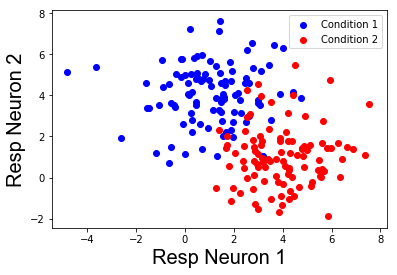

In [4]:
# seed the random num sequence so that we get consistent results every time!
np.random.seed(2)

# try out our function...
# mu0 is the mean response in each neuron under the first experimental condition
# mu1 is the mean response in each neuron under the second experimental condition
mu0 = np.array([1,4])
mu1 = np.array([4,1])

# specify covariance matrices for responses under each condition...for now lets 
# just keep them the same, with variance 2 and cov=0 (which means that the responses
# of the two neurons are independent)
cov0 = np.array([
        [2, 0],
        [0, 2]
    ])

cov1 = np.array([
        [2, 0],
        [0, 2]
    ])

# how many data points do we want to generate for each condition?
N = 100

# now call our data generating function and return data from each condition in d0 and d1
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=1)

## A few things to note about this data set - univariate vs multivariate
* You can clearly see that these neurons respond differently under our two experimental conditions
* However, if you were to average across both neurons and report univariate summary statistics, there would be NO difference between conditions!

In [5]:
# same response (within noise given 100 random samples...numbers would converge with higher N)
print('Mean response in condition 1 across neurons: ', np.mean(d0[:]))
print('Mean response in condition 2 across neurons: ', np.mean(d1[:]))

Mean response in condition 1 across neurons:  2.5677047438487888
Mean response in condition 2 across neurons:  2.502794206100768


## To exploit the fact that we have a clearly different pattern of responses across neurons, we can:
* First split the data into 'train' and 'test' sets
* Model the data in each condition using data ONLY from the training set
* For each trial of data in the test set, we can classify it as belonging to one condition or the other. 

## How do actually make the assignment of a test data vector to a class (or experimental condition)?
* The intuition is that we need to figure out how far each test vector is from the 'cloud' of data points associated with each condition)
* Simplest way: compute the mean of each data set, or cloud of points in our 2D example, and then compute the Euclidean distance between each test vector, which is a single point in our 2D data set, and each of the condition means
* Classify the test vector based on the minimum distance to each training set mean

In [ ]:
# generate some data, just like above
np.random.seed(2)
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=0)

# now lets generate a training set and a test set. We'll use 90% of our data as a training set
# and leave 10% as a test set
r,c = d0.shape  # get the shape of our data set (and d1 is the same size, so just need to get one of these)
trn_length = int(np.round(.9*r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d0[0:trn_length,:], d1[0:trn_length,:]))

# and the last 10% of the trials to the test set...
tst_data = np.vstack((d0[trn_length:,:], d1[trn_length:,:]))

# last its helpful to generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length)))
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length)))

# compute the mean of the data in each training set in the 2D space
mean0 = np.mean(trn_data[trn_labels==0,:], axis=0)
mean1 = np.mean(trn_data[trn_labels==1,:], axis=0)
print('Mean of first cond: ', mean0, ' Mean of second cond: ', mean1)

# ok, now lets just compute the distance between each test vector (2D point) and each condition mean
# first we'll do it the longer way with a loop over test trials

# allocate an array to store our classification labels  
class_labels = np.zeros(tst_data.shape[0]) 
for i in np.arange(tst_data.shape[0]):
    # compute Euc distance from each point to the mean of first condition
    # sqrt of sum if squared distances...
    distance0 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean0) , 2) ) )
    distance1 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean1) , 2) ) )
    # then figure out which distance is smaller (or which cloud our test point is closer to)
    class_labels[i] = np.argmin([distance0, distance1])
    
# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy is: ', class_acc)

## Note that in practice, we would repeatedly hold out a different set of 10% of the data as a test set and use the remaining 90% as a training set (i.e. cross-validation with many folds).

<div class="alert alert-danger">
While you can do as many folds of cross-validation as you want, so long as the train and test data are independent, always ensure that you have a balanced training set that has an equal number of trials from each of your conditions! If you don't, your classifer will generally be biased towards the condition with the most examples. This can lead to insidious above chance classification if your test set also has the same imbalance in trials in each condition!!!
</div>

## So the Euc distance approach works pretty well, but all we're doing is computing the distance from each test vector to the center of mass of each training distribution. 
* Can also weight the distance by the variance of the training set distributions
* Intuition: if a variable is very reliable (low variance), then we want to "trust" the distance more...i.e. we want to weight the final distance metric such that its biased in favor of the more reliable neurons.
* Referred to Normalized Euclidean Distance

[pooled variance formula if you want to look up...](https://en.wikipedia.org/wiki/Pooled_variance)

In [ ]:
# start here just like the last cell - only the computation of the metric is different.
# however, for fun, lets make one of our neurons super noisy
np.random.seed(2)
var_of_neuron0 = 20
var_of_neuron1 = 1

cov0 = np.array([
        [var_of_neuron0, 0],
        [0, var_of_neuron1]
    ])

cov1 = np.array([
        [var_of_neuron0, 0],
        [0, var_of_neuron1]
    ])

# generate the data and plot...
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=1)

# now lets generate a training set and a test set. We'll use 90% of our data as a training set
# and leave 10% as a test set
r,c = d0.shape  # get the shape of our data set (and d1 is the same size, so just need to get one of these)
trn_length = int(np.round(.9*r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d0[0:trn_length,:], d1[0:trn_length,:]))

# and the last 10% of the trials to the test set...
tst_data = np.vstack((d0[trn_length:,:], d1[trn_length:,:]))

# last its helpful to generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length)))
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length)))

# compute the mean of the data in each training set in the 2D space
mean0 = np.mean(trn_data[trn_labels==0,:], axis=0)
mean1 = np.mean(trn_data[trn_labels==1,:], axis=0)

# This part is just a little bit different from above
# we'll do the same basic sum of sqrt of squared differences, but we'll weigth by 
# the variance of each variable so that more reliable neurons contribute more 
# to our distance metric!
# So lets compute pooled variance (variance of each condition weighted by number of data 
# points in each condition)
numerator = ((trn_length-1) * np.var(trn_data[trn_labels==0,:], axis=0) + 
    (trn_length-1) * np.var(trn_data[trn_labels==1,:], axis=0))

denom = (trn_length-1)+(trn_length-1)

# get the variance of each neuron across both conditions 
pooled_variance = numerator / denom

# allocate an array to store our classification labels  
class_labels = np.zeros(tst_data.shape[0]) 
# and to store our Euc based classifer results for comparison
class_labels_old = np.zeros(tst_data.shape[0]) 

for i in np.arange(tst_data.shape[0]):
    # compute Norm Euc distance from each point to the mean of each condition
    distance0 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean0) / pooled_variance , 2) ) )
    distance1 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean1) / pooled_variance , 2) ) )
    # then figure out which distance is smaller (or which cloud our test point is closer to)
    class_labels[i] = np.argmin([distance0, distance1])

    # compute the plain old Euc distance based classifer for comparison
    distance0 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean0), 2) ) )
    distance1 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean1), 2) ) )
    # then figure out which distance is smaller (or which cloud our test point is closer to)
    class_labels_old[i] = np.argmin([distance0, distance1])    
    
# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with Norm Euc Dis is: ', class_acc)

class_acc_old = np.sum(class_labels_old==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with PLain Old Euc Dis is: ', class_acc_old)


## Now go back and run that last cell with var_of_neuron0 set to 20 (or larger). What happens when you compare the output using the norm euc distance to the output from just the euc distance?
* This approach is especially helpful when your variables have unequal variance

## Note that both of the above examples considered the case of independent (non-correlated) variables. 
* In other words, the response of neuron0 is not systematically related to the response of neuron1
* However, when there are correlations, the Normalized Euc distance metric can sometimes run into problems
* To see why we can just look at a cloud of points in a data set generated using correlated variables

In [ ]:
# this time lets explictly define the variance and covariance structure of the data
# to start we'll keep the variance relatively low and just mess with the cov
np.random.seed(2)
mu0 = np.array([1,4])
mu1 = np.array([4,1.5])

# variance of each neuron
var_of_neuron0 = 3
var_of_neuron1 = 3

# covariance of neurons in each experimental condition 
cov_cond_0 = 2.5
cov_cond_1 = 2.5

cov0 = np.array([
        [var_of_neuron0, cov_cond_0],
        [cov_cond_0, var_of_neuron1]
    ])

cov1 = np.array([
        [var_of_neuron0, cov_cond_1],
        [cov_cond_1, var_of_neuron1]
    ])

# generate the data and plot...
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=0)

# Plot the data
plt.scatter(d0[:,0], d0[:,1], color='b')
plt.scatter(d1[:,0], d1[:,1], color='r')
plt.xlabel('Resp Neuron 1', **fig_font)
plt.ylabel('Resp Neuron 2', **fig_font)
# then I'm going to pick one data point in this set to demonstrate the problem that can arise
plt.scatter(d0[1,0], d0[1,1], color='g', linewidths=10)
plt.legend(['Condition 1', 'Condition 2','Data pnt from C2'])
plt.show()

## So the problem here is that the green point is actually a little bit closer to the center of the Condition 2 than to the center of Condition 1 (even though its part of data set from Condition 1)...
* To fix this we need to not only account for the variance of each neuron (variable), but also account for the covariance structure of the data!
* Actually just a simple extension of the Normalized Euc Distance metric, called the Mahalonobis distance
* Its the Euc Distance weighted by the covariance structure
* Normalizing by the cov matrix has the effect of undoing the correlations between variables!

In [ ]:
# see how it works...just need data from one condition to make the point
plt.title('Correlated data')
plt.scatter(d0[:,0], d0[:,1], color='b')
plt.xlabel('Resp Neuron 1', **fig_font)
plt.ylabel('Resp Neuron 2', **fig_font)
plt.legend(['Condition 1'])
plt.show()

# now normalize by the covariance structure
# first estimate cov matrix
# rowvar = false to specify that each row is a measurement and each column is a variable
# note that rowvar is TRUE by default!!! so if you have a #trials x #variable data set
# this will return a #var x # var matrix by default...and that might not be what you want...
cm = np.cov(d0,rowvar=0)

# "whiten" data by matrix multiplying by inverse of covariance matrix
# note the @ operator, which is same as np.dot but much cleaner to write sometimes...
d0_white = d0 @ np.linalg.inv(sqrtm(cm))

# replot
plt.title('Correlation is gone!')
plt.scatter(d0_white[:,0], d0_white[:,1], color='b')
plt.xlabel('Resp Neuron 1', **fig_font)
plt.ylabel('Resp Neuron 2', **fig_font)
plt.legend(['Condition 1'])
plt.show()

## Now put this all together and do classification based on the Maha distance

In [ ]:
# make our data set...then use the Norm Euc distance and the Maha distance to classify.
np.random.seed(2)
mu0 = np.array([1,4])
mu1 = np.array([4,1.5])

# variance of each neuron
var_of_neuron0 = 3
var_of_neuron1 = 3

# covariance of neurons in each experimental condition 
cov_cond_0 = 2
cov_cond_1 = 2

cov0 = np.array([
        [var_of_neuron0, cov_cond_0],
        [cov_cond_0, var_of_neuron1]
    ])

cov1 = np.array([
        [var_of_neuron0, cov_cond_1],
        [cov_cond_1, var_of_neuron1]
    ])

# generate the data and plot...
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=1)

# now lets generate a training set and a test set. We'll use 90% of our data as a training set
# and leave 10% as a test set
r,c = d0.shape  # get the shape of our data set (and d1 is the same size, so just need to get one of these)
trn_length = int(np.round(.9*r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d0[0:trn_length,:], d1[0:trn_length,:]))

# and the last 10% of the trials to the test set...
tst_data = np.vstack((d0[trn_length:,:], d1[trn_length:,:]))

# last its helpful to generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length)))
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length)))

# compute the mean of the data in each training set in the 2D space
mean0 = np.mean(trn_data[trn_labels==0,:], axis=0)
mean1 = np.mean(trn_data[trn_labels==1,:], axis=0)

# Compute pooled variance so that we can compute the Norm distance and
# use as a comparison point for how the Maha distance metric does
numerator = ((trn_length-1) * np.var(trn_data[trn_labels==0,:], axis=0) + 
    (trn_length-1) * np.var(trn_data[trn_labels==1,:], axis=0))

denom = (trn_length-1)+(trn_length-1)

# get the variance of each neuron across both conditions 
pooled_variance = numerator / denom

# Now compute the pooled covariance estimate...use this with the maha distance metric
numerator = ((trn_length-1) * np.cov(trn_data[trn_labels==0,:], rowvar=0) + 
    (trn_length-1) * np.cov(trn_data[trn_labels==1,:], rowvar=0))

denom = (trn_length-1)+(trn_length-1)

# compute pooled covar
pooled_covariance = numerator / denom

# allocate an array to store our classification labels  
class_labels = np.zeros(tst_data.shape[0]) 
# and to store our Euc based classifer results for comparison
class_labels_norm = np.zeros(tst_data.shape[0]) 

for i in np.arange(tst_data.shape[0]):
    # use the maha distance to compute our classification 
    # we'll use a slightly different notation here in a more linear algebra friendly way...
    # this is the same as the sum of squared distances weighted (divided, or multipled by inverse) by the cov matrix
    distance0 = np.sqrt((tst_data[i,:]-mean0) @ np.linalg.inv(pooled_covariance) @ (tst_data[i,:]-mean0).T)
    distance1 = np.sqrt((tst_data[i,:]-mean1) @ np.linalg.inv(pooled_covariance) @ (tst_data[i,:]-mean1).T)
    class_labels[i] = np.argmin([distance0, distance1]) 

    # compute Norm Euc distance from each point to the mean of each condition for comparison
    distance0 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean0) / pooled_variance , 2) ) )
    distance1 = np.sqrt( np.sum( np.power( (tst_data[i,:]-mean1) / pooled_variance , 2) ) )
    # then figure out which distance is smaller (or which cloud our test point is closer to)
    class_labels_norm[i] = np.argmin([distance0, distance1]) 
    
# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with Maha Dis is: ', class_acc)

class_acc_norm = np.sum(class_labels_norm==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with Norm Euc Dis is: ', class_acc_norm)

## So when we have correlated variables, the Maha distance might be preferred over the Norm Euc distance model

## Summary
* All of the pattern recognition algorithms presented here rely on modeling the data associated with each condition and then determining some kind of fit between each 'test' vector (pattern) and the model for each condition in the training set.
* One of the simplest approaches is to just model the center of mass for each condition, and then compute the difference between each test vector and each center of mass...assign each test vector based on the min distance to each center of mass.
* This is fine if you have uncorrelated variables and each variable has equal variance. 
* If you have unequal variance, then you should also include an appropriate normilization factor. 
* To do so, you can normalize the Euc Distance by the variance of each variable, then you get the Normalized Euc distance, which is often a more suitable measure.
* If you have correlated variables (with or without equal variance) then you should consider the Mahalonobis Distance, which accounts for both the variance and covariance structure of your data. 
* Use randomization testing to eval significance...repeatedly classify with shuffled condition labels in the training set to generate a null distribution of classification accuracies